In [ ]:
from collections import Counter
import gensim
from gensim.models import Word2Vec
from gensim.models import Phrases
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
import spacy
import string

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# loading data
cat_data = pd.read_json(
    './News_Category_Dataset_v2.json',
    lines=True
)

In [ ]:
# For this exercise I want to predict the category, lets see how many articles are in each category
cat_data.groupby(['category']).count()['headline']

category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          2579
Name: h

In [ ]:
print('Total number of categories is:', len(cat_data.category.unique()))

Total number of categories is: 41


### There are 41 different categories and the number of articles per category is very different. Also, there are way too many categories for the number of samples per category. This means that predicting all this number of categories/classes wil be too hard. Lets try to decrease the number of categories by grouping similar categories.

### As a first iteration, I will use my own guesses to group these articles.

In [ ]:
def consolidate_cat(df, col_name, pattern_to_repl_list, replacement):
    df_to_clean = df
    series = df[col_name]
    
    for pattern in pattern_to_repl_list:
        replaced_series = series.str.replace(pattern, replacement)
        series = replaced_series
    df_to_clean[col_name] = series 
    return df_to_clean[['category', 'headline']]

In [ ]:
consolidate_labels = consolidate_cat(cat_data, 'category', ['ARTS & CULTURE', 'CULTURE & ARTS', 'MEDIA', 'COMEDY', 'ARTS'], 'ENTERTAINMENT')
consolidate_labels = consolidate_cat(cat_data, 'category', ['BUSINESS', 'EDUCATION', 'COLLEGE'], 'MONEY')
consolidate_labels = consolidate_cat(cat_data, 'category', ['BLACK VOICES', 'LATINO VOICES', 'QUEER VOICES'], 'DIVERSITY_VOICES')
consolidate_labels = consolidate_cat(cat_data, 'category', ['HEALTHY LIVING', 'HOME & LIVING ', 'TRAVEL', 'GOOD NEWS', 'HOME & LIVING', 'FOOD & DRINK'], 'HEALTHY_LIFESTYLES')
consolidate_labels = consolidate_cat(cat_data, 'category', ['PARENTS'], 'PARENTING')
consolidate_labels = consolidate_cat(cat_data, 'category', ['STYLE & BEAUTY', 'TASTE','WEDDINGS'], 'STYLE')
consolidate_labels = consolidate_cat(cat_data, 'category', ['THE WORLDPOST', 'WORLDPOST', 'WORLD NEWS'], 'WORLD_NEWS')
consolidate_labels = consolidate_cat(cat_data, 'category', ['FIFTY'], 'WELLNESS')
consolidate_labels = consolidate_cat(cat_data, 'category', ['CRIME', 'ENVIRONMENT', 'GREEN', 'IMPACT', 'WEIRD NEWS'], 'GENERAL')
consolidate_labels = consolidate_cat(cat_data, 'category', ['DIVORCE', 'SCIENCE', 'RELIGION', 'SPORTS', 'TECH', 'WOMEN'], 'SPECIAL_SECTIONS')

In [ ]:
# Lets see how are the articles distributed in the new categories
consolidate_labels.groupby(['category'])['headline'].count()

category
DIVERSITY_VOICES      11971
ENTERTAINMENT         27926
GENERAL               13479
HEALTHY_LIFESTYLES    28400
MONEY                  9792
PARENTING             12632
POLITICS              32739
SPECIAL_SECTIONS      18616
STYLE                 17650
WELLNESS              19228
WORLD_NEWS             8420
Name: headline, dtype: int64

### Data is definitely not perfectly balanced, but it is not too bad. Lets move forward with this dataset.

### Lets take a look at the most common words for a couple of the categories.
#### Lets take politics and Entertainment

In [ ]:
def headline_corpus(df, filter_condition):
  """
  This function joins all headlines for a single given category into a single corpus.
  Corpus is only formed of alphabetic words that are not consider stop words and are larger than 3 letters.
  """
  table = str.maketrans('', '', string.punctuation)
  stop_words = set(stopwords.words('english'))
  
  filter_condition_df = df[df['category'] == filter_condition]
  filter_condition_list = ' '.join(filter_condition_df['headline'].to_list())

  filter_condition_tokens = word_tokenize(filter_condition_list)
  filter_condition_punc_stripped = [word.translate(table).lower() for word in filter_condition_tokens]
  filter_condition_alphabet_words = [word for word in filter_condition_punc_stripped if word.isalpha() and not word in stop_words and len(word) > 3]

  return filter_condition_alphabet_words

In [ ]:
politics_corpus = headline_corpus(consolidate_labels, 'POLITICS')
entertainment_corpus = headline_corpus(consolidate_labels, 'ENTERTAINMENT')

In [ ]:
entertainment_corpus[:10]

['smith',
 'joins',
 'diplo',
 'nicky',
 'world',
 'official',
 'song',
 'hugh',
 'grant',
 'marries']

In [ ]:
def term_counter(corpus):
  counter_df = pd.DataFrame.from_dict(
      Counter(corpus), orient='index'
  ).reset_index().rename(columns={'index':'terms', 0:'counts'})
  return counter_df

In [ ]:
counter_politics_terms = term_counter(politics_corpus)
counter_entertainment_terms = term_counter(entertainment_corpus)

In [ ]:
counter_politics_terms.head()

,terms,counts
0,trump,8828
1,crackdown,50
2,immigrant,88
3,parents,52
4,puts,49


In [ ]:
def sns_barplot(x, y, data, title, x_label, y_label):
  fig, ax = plt.subplots(figsize=(12, 8))
  plot = sns.barplot(x=x, y=y, data=data, color='gray', ax=ax, edgecolor='k')
  plt.title(title, fontsize=28)
  plt.xlabel(x_label, fontsize=16)
  plt.ylabel(y_label, fontsize=16)
  plt.xticks(fontsize=12, rotation=45, ha='right')
  plt.yticks(fontsize=12)
  plt.tight_layout()
  return plot

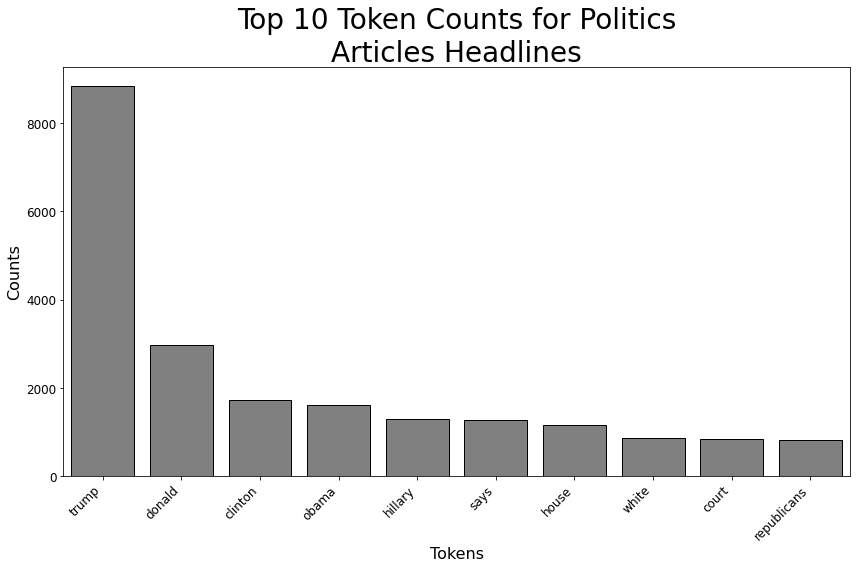

In [ ]:
sns_barplot(
    x='terms',
    y='counts', 
    data = counter_politics_terms.nlargest(10, columns='counts'),
    title= 'Top 10 Token Counts for Politics\nArticles Headlines',
    x_label='Tokens',
    y_label='Counts'
)

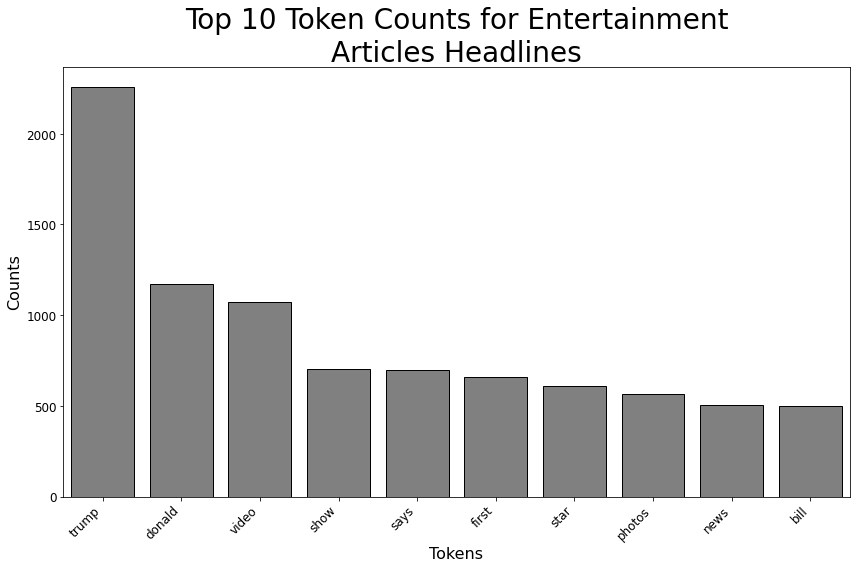

In [ ]:
sns_barplot(
    x='terms',
    y='counts', 
    data = counter_entertainment_terms.nlargest(10, columns='counts'),
    title= 'Top 10 Token Counts for Entertainment\nArticles Headlines',
    x_label='Tokens',
    y_label='Counts'
)

### This is very interesting that the 2 most dominant words for politics and entertainment articles are Trump and Donald.
### But it make sense since Donald Trump is involved in polotics and entertainment.

In [ ]:
# For speeding up model iteration during dev, I will only use 10% of the data
sub_sample_data = consolidate_labels.sample(frac=0.1, axis='index')

In [ ]:
# Lets check that the ratios of labels are similar between this subsample dataset and the whole dataset
consolidate_labels.groupby(['category'])['headline'].count()

category
DIVERSITY_VOICES      11971
ENTERTAINMENT         27926
GENERAL               13479
HEALTHY_LIFESTYLES    28400
MONEY                  9792
PARENTING             12632
POLITICS              32739
SPECIAL_SECTIONS      18616
STYLE                 17650
WELLNESS              19228
WORLD_NEWS             8420
Name: headline, dtype: int64

In [ ]:
sub_sample_data.groupby(['category'])['headline'].count()

category
DIVERSITY_VOICES      1189
ENTERTAINMENT         2736
GENERAL               1344
HEALTHY_LIFESTYLES    2889
MONEY                  980
PARENTING             1283
POLITICS              3269
SPECIAL_SECTIONS      1804
STYLE                 1823
WELLNESS              1945
WORLD_NEWS             823
Name: headline, dtype: int64

### The data was not sample unequally as the ratios for each of the classes are similar between the whole and the subsample dataset. 
### This mean we did not introduce bias duriing sample which is very important.
### Lets move on with this.

In [ ]:
def clean_stem_text(df_col_to_clean):
  """
  This function will process the raw text headlines and return headlines in 
  lowercase, without punctuation, with stemmed only of words that are 
  larger than 3 characters
  """
  table = str.maketrans('', '', string.punctuation)
  stop_words = set(stopwords.words('english'))
  porter = PorterStemmer()
  stemmed_tokens = []

  for row in df_col_to_clean:
      tokens = word_tokenize(row)
      punc_stripped = [word.translate(table).lower() for word in tokens]
      alphabet_words = [word for word in punc_stripped if word.isalpha() and not word in stop_words and len(word) > 3]
      stemmed = [porter.stem(word) for word in alphabet_words]
      stemmed_tokens.append(stemmed)
  return [' '.join(stemmed_list) for stemmed_list in stemmed_tokens]

In [ ]:
stemmed_sentences = clean_stem_text(sub_sample_data['headline'])

In [ ]:
def split_train_test(X=None, y=None, random_state=6059, stratify=None, test_size=0.15):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
      X,
      y,
      stratify=y,
      random_state=random_state,
      test_size=test_size
  )
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_train_test(
    X=stemmed_sentences,
    y=sub_sample_data['category'],
    random_state=6059,
    stratify=sub_sample_data['category'],
    test_size=0.15
)

In [ ]:
def tfidf_ngram(X_train, X_test, analyzer, ngram_range):
  """
  This function leverages TFidf vectorizer to output tf-idf ngrams for model training
  """
  tfidf_vect_ngram = TfidfVectorizer(analyzer=analyzer, ngram_range=ngram_range)
  tfidf_vect_ngram.fit(X_train)
  X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
  X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
  return X_train_tfidf_ngram, X_test_tfidf_ngram

In [ ]:
# Lets get tf-idf bigrams to train a headline classifier
X_train_tfidf_ngram_word, X_test_tfidf_ngram_word = tfidf_ngram(X_train, X_test, analyzer='word', ngram_range=(2,2))

In [ ]:
def train_model(clf, X_train, y_train, X_test, y_test, parameters_dict):
  clf_grid = GridSearchCV(estimator=clf, param_grid=parameters_dict, cv=3, scoring='f1_weighted', n_jobs=-1)
  clf_grid.fit(X_train, y_train)
  predictions = clf_grid.predict(X_test)

  prec_weighted = metrics.precision_score(predictions, y_test, average='weighted')
  recall_weighted = metrics.recall_score(predictions, y_test, average='weighted')
  f1_weighted = metrics.f1_score(predictions, y_test, average='weighted')
  
  return prec_weighted, recall_weighted, f1_weighted, clf_grid.best_params_

In [ ]:
prec_weighted, recall_weighted, f1_weighted, best_params = train_model(
    naive_bayes.MultinomialNB(),
    X_train_tfidf_ngram_word,
    y_train,
    X_test_tfidf_ngram_word,
    y_test,
    dict(alpha=[0.5, 1])
)

print("NB, bigram word level vectors, precision weighted: ", prec_weighted)
print("NB, bigram word level vectors, recall weighted: ", recall_weighted)
print("NB, bigram word level vectors, f1 score weighted: ", f1_weighted)
print("Best model parameters:", best_params)

NB, bigram word level vectors, precision weighted:  0.6988474107551638
NB, bigram word level vectors, recall weighted:  0.3385330235645536
NB, bigram word level vectors, f1 score weighted:  0.37743069865105405
Best model parameters: {'alpha': 0.5}


In [ ]:
prec_weighted, recall_weighted, f1_weighted, best_params = train_model(
    linear_model.LogisticRegression(solver='saga'),
    X_train_tfidf_ngram_word,
    y_train,
    X_test_tfidf_ngram_word,
    y_test,
    dict(C=[0.1, 1], penalty=['elasticnet'], l1_ratio=[0, 0.5])
)

print("LR, bigram word level vectors, precision weighted: ", prec_weighted)
print("LR, bigram word level vectors, recall weighted: ", recall_weighted)
print("LR, bigram word level vectors, f1 score weighted: ", f1_weighted)
print("Best model parameters:", best_params)

LR, bigram word level vectors, precision weighted:  0.6895729793031814
LR, bigram word level vectors, recall weighted:  0.3521407235313641
LR, bigram word level vectors, f1 score weighted:  0.38628316405472635
Best model parameters: {'C': 1, 'l1_ratio': 0, 'penalty': 'elasticnet'}


In [ ]:
prec_weighted, recall_weighted, f1_weighted, best_params = train_model(
    ensemble.RandomForestClassifier(n_jobs=-1),
    X_train_tfidf_ngram_word,
    y_train,
    X_test_tfidf_ngram_word,
    y_test,
    dict(min_samples_split = [3, 5])
)

print("RandomForest, bigram word level vectors, precision weighted: ", prec_weighted)
print("RandomForest, bigram word level vectors, recall weighted: ", recall_weighted)
print("RandomForest, bigram word level vectors, f1 score weighted: ", f1_weighted)
print("Best model parameters:", best_params)

RandomForest, bigram word level vectors, precision weighted:  0.5995081758647327
RandomForest, bigram word level vectors, recall weighted:  0.31928310653833386
RandomForest, bigram word level vectors, f1 score weighted:  0.29776842092209826
Best model parameters: {'min_samples_split': 3}


### This is very interesting. All three models f1 score is similar.
### If I was going to implement this model as it is, I'd select Naive Bayes since training time is very short, predictions are fast, and the model is very easy to implement.

# Lets try to use a better representation of text for model training.
# Lets get a spaCy embedding

In [ ]:
# load a small english pretrained model
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
def spacy_embedding_sm(text_to_embed_df):
  nlp_model = spacy.load('en_core_web_sm')
  embedding_list = []

  for row in text_to_embed_df:
    trained_model = nlp_model(row)
    embedding_list.append(trained_model.vector)
  
  return embedding_list

In [ ]:
embedding_vector = spacy_embedding_sm(sub_sample_data.headline)

In [ ]:
# Lets create a dataframe with the vectors and labels
embeddings_sm = pd.DataFrame(
    {
        'headline_embedding': embedding_vector,
        'category_label': sub_sample_data['category']
    }
)

In [ ]:
# Lets transform the embedding vector into columns
embedding_to_cols = pd.DataFrame(embeddings_sm.headline_embedding.to_list())

In [ ]:
embedding_to_cols['category_label'] = cat_headline['category']

In [ ]:
embedding_to_cols.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,category_label
0,1.140857,-2.609909,-2.195710,0.637792,-0.349784,2.360854,0.518369,1.117762,1.369088,1.304815,1.267790,0.625943,1.834827,0.982447,-1.591405,0.115479,-0.466000,0.153633,-1.074231,-1.115513,0.619103,-0.115635,-0.288565,-1.660075,-0.713260,-1.640297,1.306331,-2.478976,1.012866,-1.291123,0.016046,-0.510341,-0.104477,-1.701108,0.870750,-2.291791,3.328615,-1.926158,-2.482868,0.546651,...,2.610426,0.169582,0.243820,-1.027479,-0.752138,-0.196922,1.105837,3.503361,0.618732,0.946458,-0.269145,0.029390,1.162069,-1.992232,-0.488090,0.706329,0.541078,-1.770101,-0.725742,1.010039,-1.100719,-1.293287,0.170025,3.099810,-2.262345,-0.761190,-0.234380,-0.086826,1.388062,1.288979,-0.493908,-0.768045,0.941723,0.020388,1.108636,0.444351,1.084300,1.749161,1.611914,GENERAL
1,1.259468,-0.776940,-0.579592,1.044159,1.420292,3.122792,1.443577,0.053617,0.669814,1.259212,1.864674,-0.103573,-0.340544,-0.539682,-1.966192,-0.347496,0.585227,-0.160008,-0.656448,-0.867281,1.045728,-0.307711,0.491358,-1.121588,-0.826428,0.749607,0.510034,-1.023465,-0.160156,-1.527526,0.697861,0.139412,-0.179027,-0.593586,-0.118062,-2.056243,2.644691,-0.611299,-1.882790,-0.617266,...,1.392370,-0.011406,-0.794635,-0.915041,-0.879776,0.600128,-0.115955,1.005654,0.532454,0.087919,-1.637310,-0.060851,0.110745,-1.722876,0.064299,-0.130868,-0.758086,-0.560701,-0.147194,0.462606,-0.401264,-0.765977,0.010196,1.821644,-2.338571,-0.188468,0.279671,1.156868,1.672989,-0.317935,0.024258,0.473143,0.120411,0.329222,0.653812,-0.030926,0.144347,1.919709,0.605550,ENTERTAINMENT
2,0.176791,-1.853577,0.069344,1.109756,1.181195,2.263872,0.312616,-0.416202,2.045497,1.133811,1.437436,2.098691,-1.115247,-0.186085,-2.736078,-1.221942,0.053159,0.962036,1.010372,-1.433825,1.341026,-0.529049,0.249424,-2.045713,-1.149785,-0.267201,-0.041390,-0.078238,1.099423,-1.646536,0.688197,-0.836711,-1.127869,-0.318325,-1.037568,-2.117240,1.614409,-0.893201,-1.714206,-0.095804,...,1.002202,0.511959,-1.090742,-0.210388,0.201614,2.021174,0.431002,2.055828,-0.245411,1.643093,-0.601315,-1.553508,0.539282,-0.738123,-0.621267,1.018830,1.023390,-0.202876,-1.310314,-0.015272,-0.809676,-0.045430,-0.618891,0.949976,-0.573592,-0.537078,-0.097307,1.950005,2.108545,0.651515,-0.655175,-1.615230,-0.370074,-0.776830,1.810327,1.409194,-0.034173,0.568665,1.293576,ENTERTAINMENT
3,1.234624,-0.374253,-1.163900,0.175534,0.509071,2.236867,2.268734,0.042993,2.045069,1.152872,1.175385,-0.319540,1.358696,-0.479121,0.719989,-0.638196,-1.138774,-0.826142,-0.505619,-1.886323,2.088624,-0.455953,0.038795,-1.584551,-0.512796,-1.295683,0.073874,-2.161477,0.390557,-0.011208,0.789470,1.130061,-1.032327,0.774984,-0.729001,-2.037723,2.303461,-0.219036,-2.037813,-0.697561,...,0.890302,-0.476242,-0.006005,0.455705,-0.881315,-0.702899,1.342829,-0.679261,0.434314,0.485334,-0.532833,0.239399,1.570176,-1.711462,-0.666128,0.277183,-1.270758,-0.751820,-0.922715,1.572525,-0.641867,-0.299904,-0.545764,1.470248,-0.456829,-0.386734,1.050338,0.861844,-1.077094,0.513306,0.479860,-0.039636,0.669834,-0.248279,-0.729930,0.311826,-0.576441,1.649982,0.713631,ENTERTAINMENT
4,1.944394,-0.787141,-1.233187,0.388701,1.127845,3.282583,1.301213,0.998176,2.963668,2.896556,2.484595,-1.212965,0.741951,-0.403252,-1.220446,-0.600047,0.368974,0.006047,-0.636181,-1.063867,0.544793,0.111374,1.188163,-1.373455,-0.948998,-1.532819,1.328606,-1.284049,-0.204037,-1.288783,0.788964,-0.136086,-0.184967,-0.712526,0.214116,-2.174511,2.298115,-1.281193,-2.248376,-1.268202,...,2.977538,0.418242,-0.882733,0.843055,-1.743722,-0.262917,1.120675,0.302765,-0.277236,0.158953,-0.741240,0.037791,1.117146,-1.920827,0.434980,0.182599,-0.990018,-0.390326,-0.784852,0.526335,-0.471720,-0.733014,0.438288,2.319479,-1.238159,-0.678485,0.323808,0.747791,1.372770,-0.623400,-0

In [ ]:
# Sometimes there are nulls introduce while the embedding is formed.
embedding_to_cols.isnull().sum().sum()

96

### Since there are only 96 nulls, lets drop them.

In [ ]:
embedding_to_cols_no_nulls = embedding_to_cols.dropna()

In [ ]:
embedding_to_cols_no_nulls.isnull().sum().sum()

0

In [ ]:
# creating df of features or vectors
X_embeddings = embedding_to_cols_no_nulls.drop('category_label', axis='columns')
y_labels = embedding_to_cols_no_nulls.category_label

In [ ]:
X_train, X_test, y_train, y_test = split_train_test(
    X=X_embeddings,
    y=y_labels,
    random_state=6059,
    stratify=y_labels,
    test_size=0.15
)

In [ ]:
# logistic regression is very sensitive to multicolinearity of features. Lets decrease it
pca = PCA(n_components=96)
pca.fit(X_train)
transformed_vectors_X_train = pca.transform(X_train)
transformed_vectors_X_test = pca.transform(X_test)

In [ ]:
len(transformed_vectors_X_test[0])

96

In [ ]:
transformed_vectors_X_test[0]

array([-7.79511355e-01, -7.87447209e-01,  3.28297479e-02,  1.34002809e+00,
        1.56211057e+00, -9.43838885e-01,  2.80028164e-01, -8.46284946e-01,
        2.31350224e+00,  1.56986313e-01,  1.76920543e+00,  9.75767058e-01,
       -1.24124898e-01, -6.83227707e-01,  1.03545275e+00,  2.99754355e-01,
       -1.50452192e-03, -1.71663682e+00,  6.45822988e-01,  3.44911007e-01,
       -3.79504448e-01, -2.57413864e-01,  6.08082327e-01, -2.55473127e-01,
        7.58028591e-02, -5.62711405e-01,  5.77112672e-01, -5.83595652e-01,
       -8.04613853e-03,  6.40001560e-01, -9.07875678e-03,  2.57361711e-01,
       -2.72440103e-02, -6.47989612e-02, -3.78886026e-01,  3.03175414e-01,
       -3.87344863e-01, -8.67367011e-01, -2.64885320e-01,  1.37132969e-01,
       -2.08524292e-01,  1.32668875e-01, -8.26607588e-02, -2.12040787e-01,
       -1.79126979e-01, -8.79785372e-03, -2.36947294e-01, -3.86503222e-02,
       -7.05461811e-01,  2.69967254e-01, -6.14127443e-01,  6.00556094e-02,
       -1.64006973e-01,  

### In this case I am only going to try Logistic regression and Random forest. Naive Bayes doesn't work with negative values and some of the vector values are negative. An alternative to this would be to square the vectors. Something that can be done in a second iteration.
### As before, I'll pay close attention to f1 score.

In [ ]:
prec_weighted, recall_weighted, f1_weighted, best_params = train_model(
    linear_model.LogisticRegression(solver='saga',  max_iter=1000),
    transformed_vectors_X_train,
    y_train,
    transformed_vectors_X_test,
    y_test,
    dict(C=[0.1, 1], penalty=['elasticnet'], l1_ratio=[0, 0.5])
)

print("LR, ensemble, precision weighted: ", prec_weighted)
print("LR, ensemble, recall weighted: ", recall_weighted)
print("LR, ensemble, f1 score weighted: ", f1_weighted)
print("Best model parameters:", best_params)

LR, ensemble, precision weighted:  0.9558118854877052
LR, ensemble, recall weighted:  0.34616661135081317
LR, ensemble, f1 score weighted:  0.505531816673204
Best model parameters: {'C': 1, 'l1_ratio': 0, 'penalty': 'elasticnet'}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prec_weighted, recall_weighted, f1_weighted, best_params = train_model(
    ensemble.RandomForestClassifier(),
    transformed_vectors_X_train,
    y_train,
    transformed_vectors_X_test,
    y_test,
    dict(min_samples_split = [3, 5], n_estimators = [100, 1000])
)

print("RandomForest, bigram word level vectors, precision weighted: ", prec_weighted)
print("RandomForest, bigram word level vectors, recall weighted: ", recall_weighted)
print("RandomForest, bigram word level vectors, f1 score weighted: ", f1_weighted)
print("Best model parameters:", best_params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomForest, bigram word level vectors, precision weighted:  0.8165903819385053
RandomForest, bigram word level vectors, recall weighted:  0.33388649186856956
RandomForest, bigram word level vectors, f1 score weighted:  0.4640174473814614
Best model parameters: {'min_samples_split': 3, 'n_estimators': 100}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Interestng. As before logistic regression outperforms by a bit random forest as measure by the f1 score.
### It is worth mentioning that precision is quite high, whereare recall is very low. This indicates that there is a large number of false negative and point to a potential mistake in reconsolidating the labels.

## Next steps:
### Get more compute power and train models using whole dataset
### Reconsolidate labels using a similarity metric like cosine similarity. It is very likely that my guesses are wrong.
### Create embeddings using more complex model embeddings. I'd specifically be interested on using Bert, since it performs quite well for text classification.
### Use a more complex classification models such as neural networks. This will be great to account for not linear interactions of the features.